# Import Modules

In [1]:
import glob
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import gc
import itertools
from pathlib import Path

import pandas as pd
from functools import partial
from tqdm.notebook import trange, tqdm
import umap
from sklearn.decomposition import PCA

import yaml
from torchvision import transforms
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
sys.path.insert(0, os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-GAN'))
from implementations.infogan.datasets import WCDataset
from implementations.infogan.infogan import weights_init_normal, Generator, Discriminator

import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })

########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    if path in basepath.as_posix():
        return basepath
    elif not (basepath / path).exists():
        (basepath / path).mkdir(exist_ok=True,parents=True)
        print('Added Directory:'+ (basepath / path).as_posix())
        return (basepath / path)
    else:
        return (basepath / path)

rootdir = Path('~/Research/FMEphys/').expanduser()

# Set up partial functions for directory managing
# join = partial(os.path.join,rootdir)
# checkDir = partial(check_path,rootdir)
FigurePath = check_path(rootdir,'Figures')
savefigs=False

# %matplotlib widget

# Load Network

In [2]:
n = -1
version = 0
modeltype = 'InfoGan' 
filename =  Path('~/Research/FMEphys/GAN_Logs/{}/version_{:d}/config.yaml'.format(modeltype,version)).expanduser()
ckpt_path = list(Path('~/Research/FMEphys/GAN_Logs/{}/version_{:d}/checkpoints/'.format(modeltype,version)).expanduser().glob('*.pt'))[n]

print(ckpt_path)
Epoch = int(ckpt_path.stem.split('_')[-1])

with open(filename, 'r') as file:
    try:
        opt = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


# config['exp_params']['data_path'] = os.path.expanduser('~/Research/FMEphys/data')
# config['exp_params']['csv_path_train'] = os.path.expanduser('~/Research/FMEphys/WC3d_Train_Data_SingVid.csv')
# config['exp_params']['csv_path_val'] = os.path.expanduser('~/Research/FMEphys/WC3d_Val_Data_SingVid.csv')
# config['logging_params']['save_dir'] = os.path.expanduser('~/Research/FMEphys/logs2/')
print(opt)
FigurePath = check_path(FigurePath/modeltype,'version_{:d}'.format(version))

/home/eabe/Research/FMEphys/GAN_Logs/InfoGan/version_0/checkpoints/checkpoint_90.pt
{'b1': 0.5, 'b2': 0.999, 'batch_size': 1024, 'channels': 1, 'code_dim': 2, 'img_size': 64, 'latent_dim': 64, 'lr': 0.0002, 'n_classes': 10, 'n_cpu': 8, 'n_epochs': 1000, 'sample_interval': 10}


In [3]:
cuda = True if torch.cuda.is_available() else False
train_path = os.path.expanduser("~/Research/FMEphys/WC3d_Train_Data.csv")
val_path = os.path.expanduser("~/Research/FMEphys/WC3d_Val_Data.csv")
SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((64,64)),
                                transforms.ToTensor(),
                                SetRange])

dataset = WCDataset(root_dir = os.path.expanduser("~/Research/FMEphys/data/"),
                                csv_file = train_path,
                                transform=transform
                                )

dataloader = DataLoader(dataset,
                        batch_size= opt['batch_size'],
                        shuffle = True,
                    #   drop_last=True,
                        num_workers=opt['n_cpu'],
                        persistent_workers=True,
                        pin_memory=True,
                        prefetch_factor=10)


# Initialize generator and discriminator
generator = Generator(opt)
discriminator = Discriminator(opt)

if cuda:
    generator.cuda()
    discriminator.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt['lr'], betas=(opt['b1'], opt['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt['lr'], betas=(opt['b1'], opt['b2']))
optimizer_info = torch.optim.Adam(
    itertools.chain(generator.parameters(), discriminator.parameters()), lr=opt['lr'], betas=(opt['b1'], opt['b2'])
)

In [4]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
def to_categorical(y, num_columns):
    """Returns one-hot encoded Variable"""
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y.astype(int)] = 1.0

    return Variable(FloatTensor(y_cat))

In [5]:
checkpoint = torch.load(ckpt_path)

In [6]:
generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
optimizer_G.load_state_dict(checkpoint['optimizer_G'])
optimizer_D.load_state_dict(checkpoint['optimizer_D'])
optimizer_info.load_state_dict(checkpoint['optimizer_info'])

In [51]:
# Static sample
n_row=10
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt['latent_dim']))))
static_code = Variable(FloatTensor(np.zeros((opt['n_classes'] ** 2, opt['code_dim']))))
static_label = to_categorical(
    np.array([num for _ in range(opt['n_classes']) for num in range(opt['n_classes'])]), num_columns=opt['n_classes']
)
static_sample = generator(z, static_label, static_code)

In [53]:
static_sample.shape

torch.Size([100, 1, 64, 64])

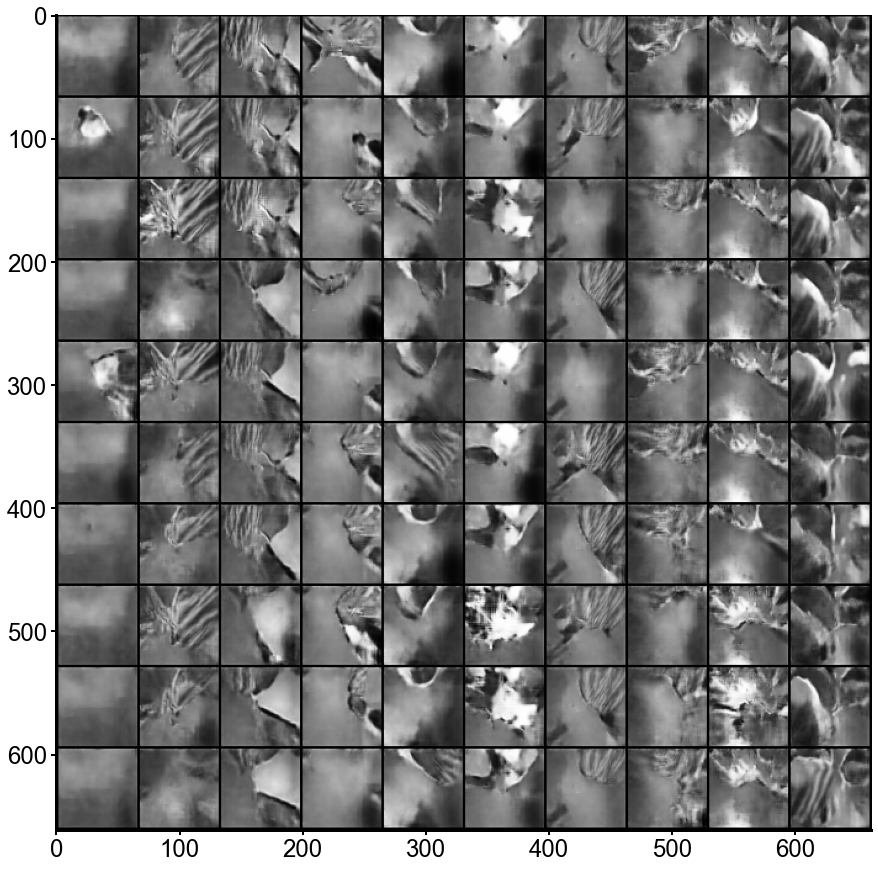

In [52]:
im_grid = vutils.make_grid(static_sample.data.cpu().detach(),nrow=n_row, normalize=True)
plt.figure(figsize=(15,15))
plt.imshow(im_grid.permute(1,2,0))

In [9]:
# Get varied c1 and c2
static_z = Variable(FloatTensor(np.zeros((opt['n_classes'] ** 2, opt['latent_dim']))))
zeros = np.zeros((n_row ** 2, 1))
c_varied = np.repeat(np.linspace(-5, 5, n_row)[:, np.newaxis], n_row, 0)
c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))
with torch.no_grad():
    sample1 = generator(static_z, static_label, c1).cpu()
    sample2 = generator(static_z, static_label, c2).cpu()

im_grid1 = vutils.make_grid(sample1.data,nrow=n_row, normalize=True).permute(1,2,0)
im_grid2 = vutils.make_grid(sample2.data,nrow=n_row, normalize=True).permute(1,2,0)


(-0.5, 661.5, 661.5, -0.5)

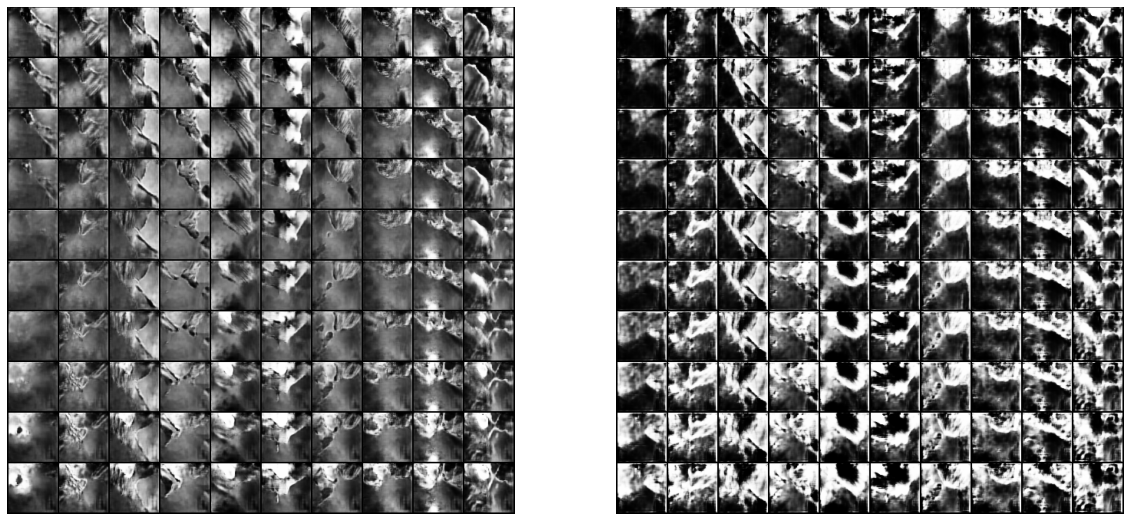

In [11]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].imshow(im_grid1)
axs[0].axis('off')
axs[1].imshow(im_grid2)
axs[1].axis('off')

In [33]:
static_label.shape,static_code.shape

(torch.Size([100, 10]), torch.Size([100, 2]))

In [41]:
zeros = np.zeros((n_row ** 2, 1))
c_varied = np.repeat(np.linspace(-5, 5, n_row)[:, np.newaxis], n_row, 0)
c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))


torch.Size([10, 64])

In [43]:
z = np.repeat(np.linspace(-5, 5, n_row)[:, np.newaxis], n_row, 0)

In [49]:
np.zeros((n_row**2, opt['latent_dim']))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
np.linspace(-5, 5, n_row)[:, np.newaxis]

array([[-5.        ],
       [-3.88888889],
       [-2.77777778],
       [-1.66666667],
       [-0.55555556],
       [ 0.55555556],
       [ 1.66666667],
       [ 2.77777778],
       [ 3.88888889],
       [ 5.        ]])

In [ ]:
for comp in trange(opt['latent_dim']):
    temp = np.linspace(-5, 5, n_row)[:, np.newaxis]